## **SIFT + KNN (K Value = 1) MAX_KEY_PADDING approach**
#### **k=1, Accuracy = 23%**
#### **Test run - 1**

#### **Aim: To find the accuracy of the model by taking k value = 1.**

#### **For mounting drive**

In [1]:
#For mounting GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Required modules**

In [2]:
#Req. opencv 4.5+
!pip uninstall opencv-python
!pip install opencv-python

Found existing installation: opencv-python 4.5.4.60
Uninstalling opencv-python-4.5.4.60:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.5.4.60.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Gui-ba0a2070.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5XcbQpa-ca221f44.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/di

In [3]:
#Importing necessary libraries
from zipfile import ZipFile
from tensorflow.python.client import device_lib
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import cv2
import os
import sys
import numpy as np
import random

#### **Functions definition**

In [4]:
def extract_zip(file_name = "drive/MyDrive/Dataset_test_1.zip"):
    with ZipFile(file_name, "r") as zip:
        zip.extractall()
        print("Dataset Extracted")

In [5]:
def python_ver():
    print("\nPython version:\n")
    print(sys.version)

def device_info():
    print("\nDevice Info:\n")
    print(device_lib.list_local_devices())

def platform_info():
    print("\nPlatform Info:\n")
    print(platform.platform())
    print(platform.processor())

In [6]:
def SIFT_test(dirs, labels, img_size):
    """Scale Invariant Feature Transform Test run for finding the maximum keypoints detected among all the images in the dataset"""
    
    max_key = 0
    
    for data_dir in dirs:
        for label in labels:
            path = os.path.join(data_dir, label)
            for img in os.listdir(path):
                #Reading the image in grayscale mode
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                   
                #Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 

                #detecting keypoints
                sift = cv2.SIFT_create()
                keypoints = sift.detect(resized_arr, None)

                if (len(keypoints) > max_key):
                    max_key = len(keypoints)
                
    return max_key

In [7]:
def SIFT(image, max_key):
    """Scale Invariant Feature Transform for finding keypoints and computing descriptors"""
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return np.pad(np.array(descriptors, dtype="i"), ((0, max_key-len(keypoints)), (0, 0)))[:max_key]

In [8]:
def dataset_creation(data_dir, labels, img_size, max_key):
    """Loading data and shuffling"""
    data = [] 

    for class_num, label in enumerate(labels): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                #Reading the image in grayscale mode
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                #Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 

                #SIFT function call
                SIFT_img_desc = SIFT(resized_arr, max_key)
                
                data.append([SIFT_img_desc, class_num])
            except Exception as err:
                print("Error:\n",err)
    
    random.shuffle(data)
    return np.array(data)

In [9]:
def dataset_creation_train_stat(labels, train):
    """Plot initial data graph"""
    list_graph = []
    for i in train:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))    
    sns.countplot(list_graph)
    plt.title("Train set")
    plt.show()


def dataset_creation_test_stat(labels, test):
    """Plot initial data graph"""
    list_graph = []
    for i in test:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))
    sns.countplot(list_graph)
    plt.title("Test set")
    plt.show()

In [10]:
def train_test_data_split(train, test):
    """train and test"""
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for feature, label in train:
        x_train.append(feature.flatten())
        y_train.append(label)

    for feature, label in test:
        x_test.append(feature.flatten())
        y_test.append(label)

    return (np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test))

In [11]:
def build_model_knn(x_train, y_train, k):
    """Builds KNN model"""
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(x_train, y_train)
    
    return model

In [12]:
def acc_results(model, labels, x_test, y_test):
    """Prediction and test accuracy"""
    predictions = model.predict(x_test)
    print(classification_report(y_test, predictions, target_names = labels))
    accuracy = accuracy_score(y_test, predictions)*100 
    print("\nAccuracy = "+str(accuracy)+"%")

#### **Making Function calls and defining variables**

In [13]:
#Extracting Dataset
extract_zip("drive/MyDrive/Dataset_test_1.zip")

#Device and environment Info
python_ver()
device_info()
platform_info()

Dataset Extracted

Python version:

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Device Info:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14688423068399289422
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12682280776030160872
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]

Platform Info:

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
x86_64


In [14]:
#Variables
dirs = ["Dataset_test_1/Train", "Dataset_test_1/Test"]
labels = ['Buddha', 'Garuda', 'Goddess_Durga', 'Goddess_Lakshmi', 'Goddess_Saraswathi', 'Lord_Ganesh', 
        'Lord_Hanuman', 'Lord_Hayagriva', 'Lord_Indra', 'Lord_Krishna', 'Lord_Muruga', 'Nandi', 'Nataraj', 
        'Shirdi_Sai_Baba', 'Shivling']
img_size = 224
k = 1

In [15]:
#Max keypoints detection
max_key = SIFT_test(dirs, labels, img_size)

#Train and Test data loading
train = dataset_creation("Dataset_test_1/Train", labels, img_size, max_key)
test = dataset_creation("Dataset_test_1/Test", labels, img_size, max_key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


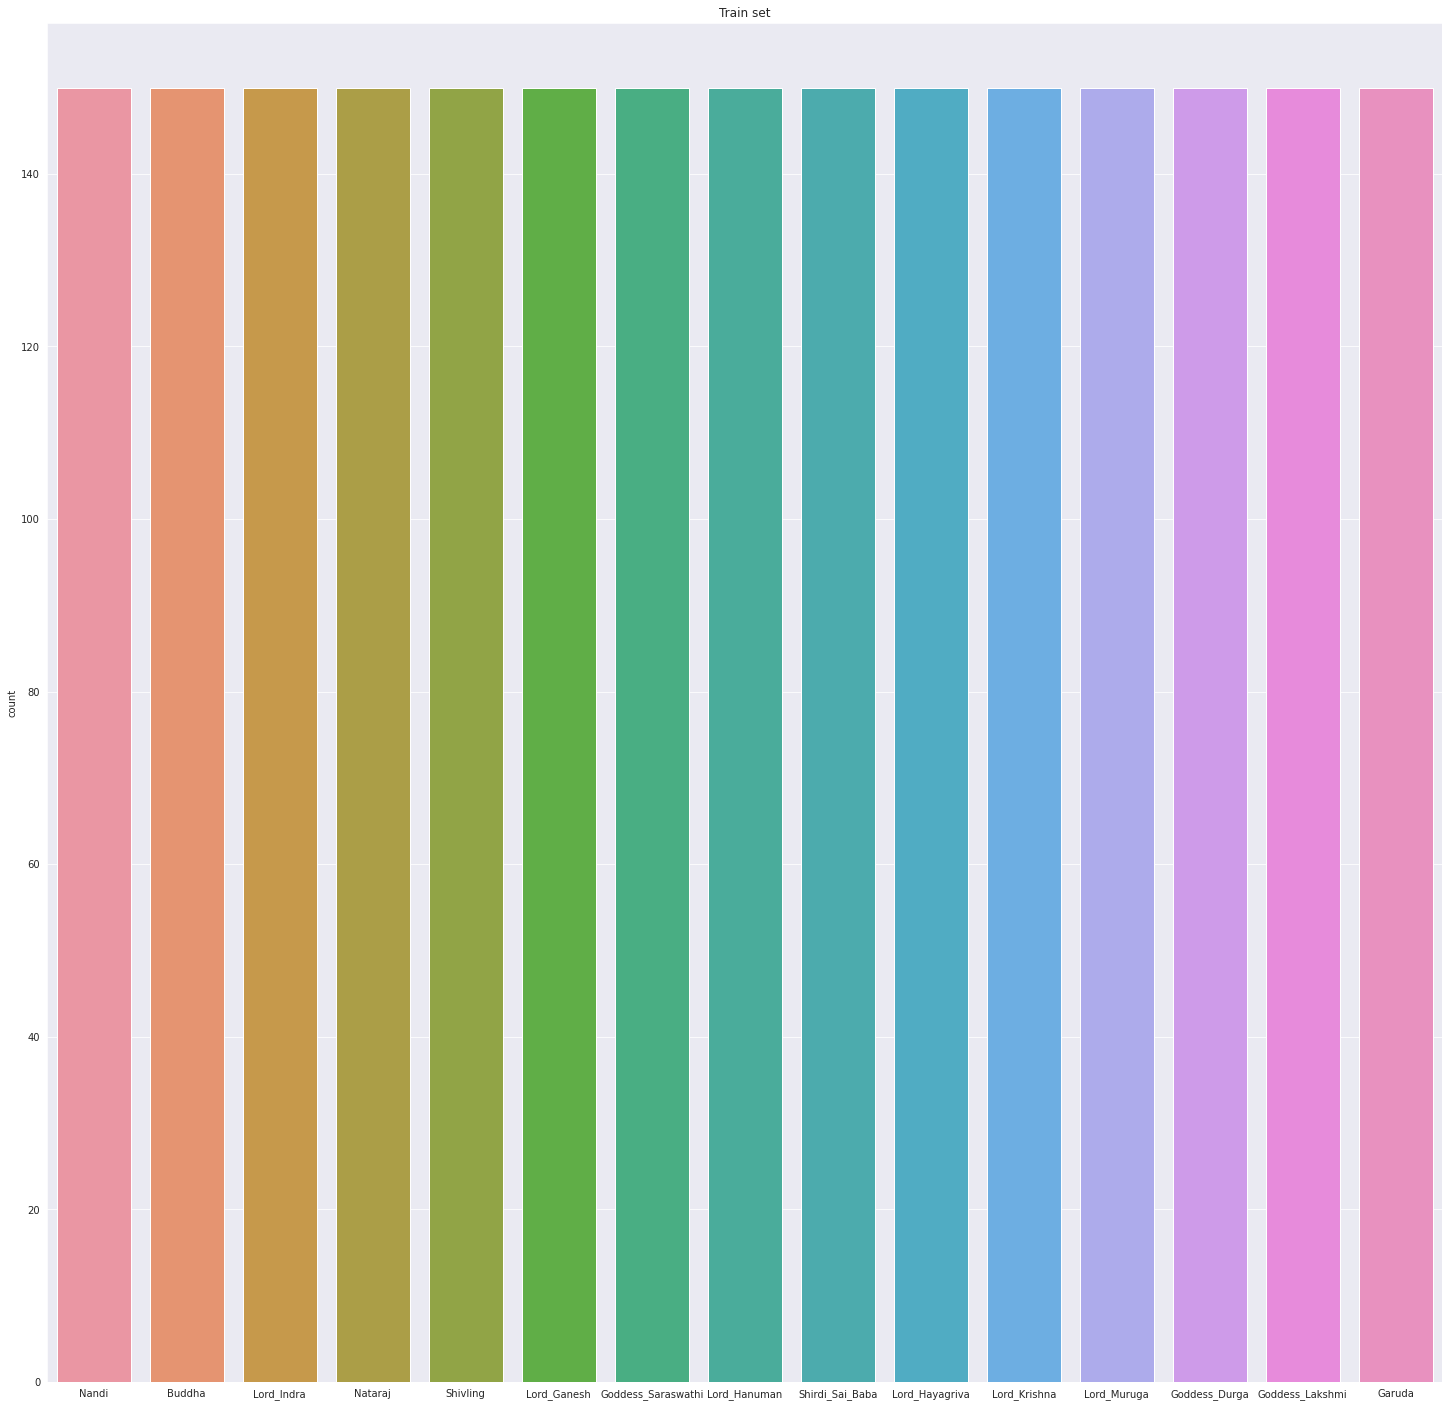

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


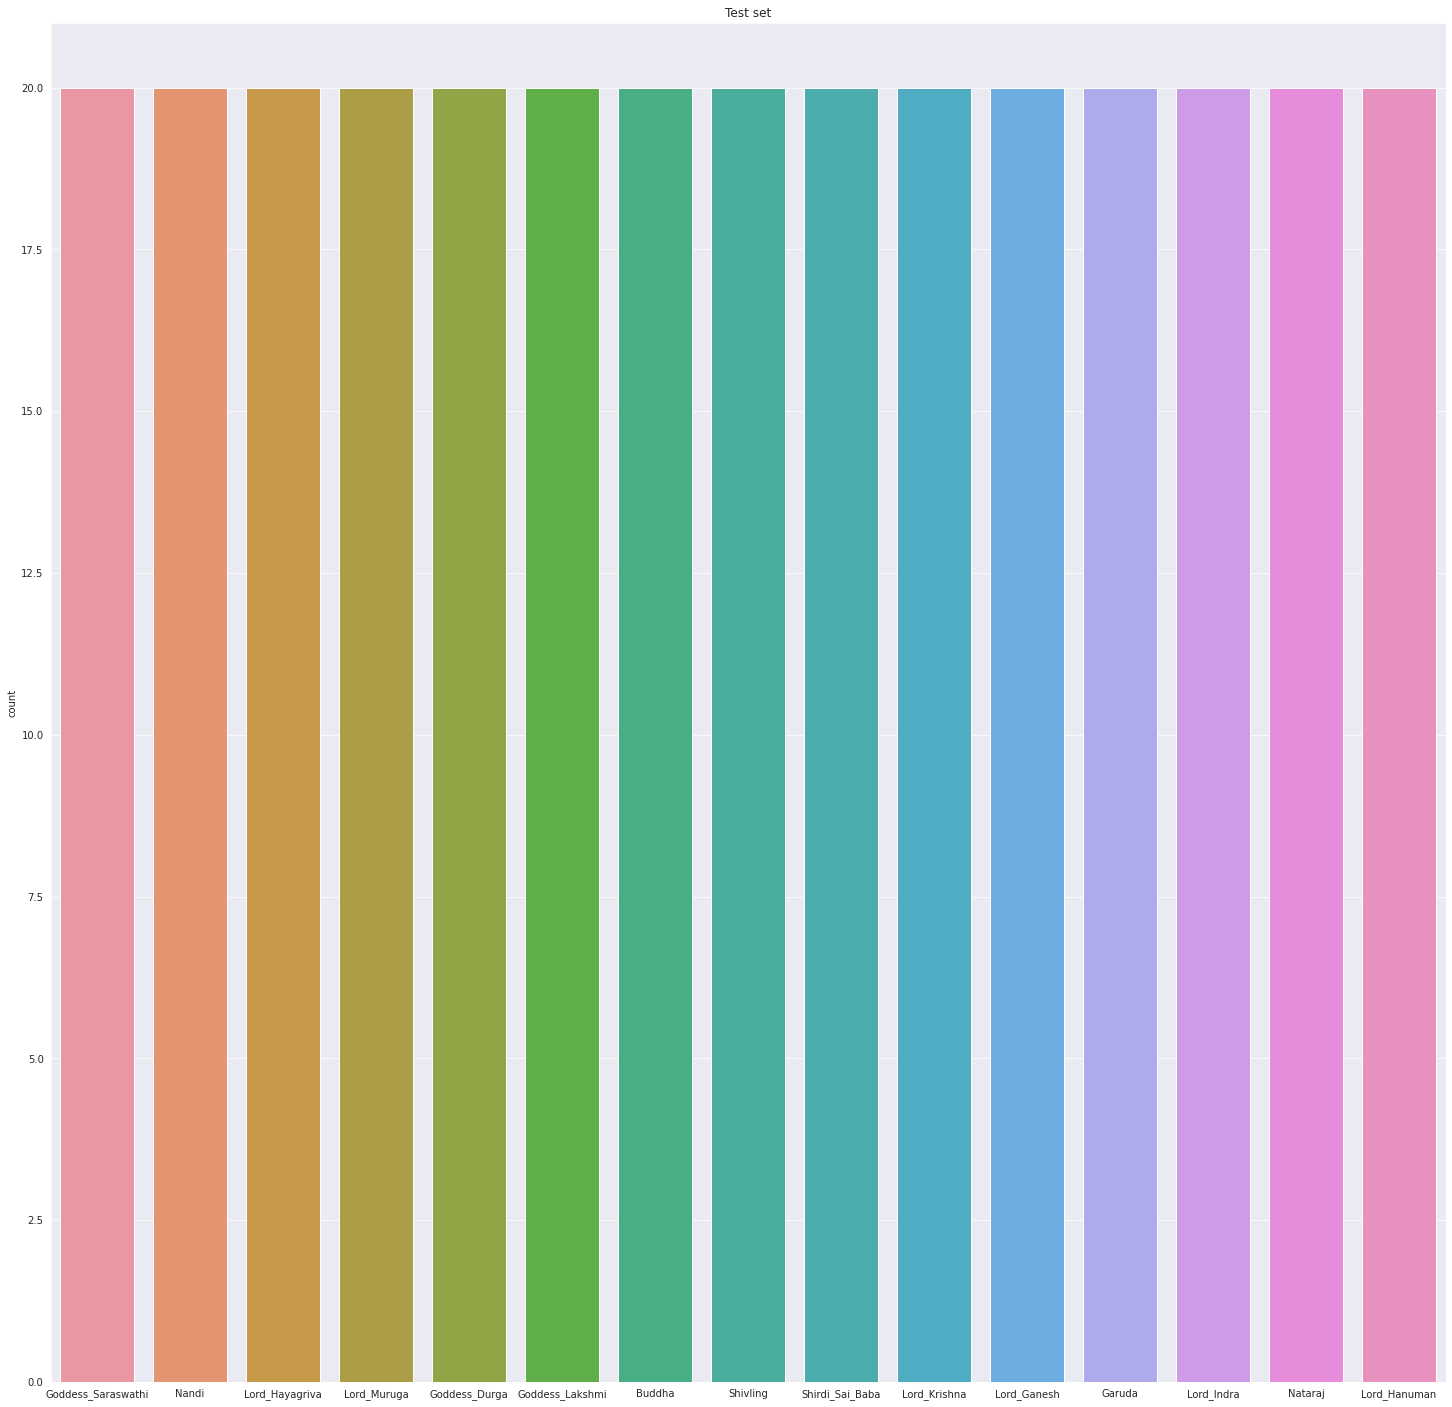

In [16]:
#Stats
dataset_creation_train_stat(labels, train)
dataset_creation_test_stat(labels, test)

In [17]:
#Training and testing data
x_train, y_train, x_test, y_test = train_test_data_split(train, test)

In [18]:
#Building KNN Model
model = build_model_knn(x_train, y_train, k)

In [19]:
#Results
print("k value:",k)
acc_results(model, labels, x_test, y_test)

k value: 1
                    precision    recall  f1-score   support

            Buddha       0.13      0.35      0.19        20
            Garuda       0.83      0.50      0.62        20
     Goddess_Durga       0.00      0.00      0.00        20
   Goddess_Lakshmi       0.00      0.00      0.00        20
Goddess_Saraswathi       0.00      0.00      0.00        20
       Lord_Ganesh       0.00      0.00      0.00        20
      Lord_Hanuman       0.00      0.00      0.00        20
    Lord_Hayagriva       1.00      0.05      0.10        20
        Lord_Indra       1.00      1.00      1.00        20
      Lord_Krishna       0.14      0.05      0.07        20
       Lord_Muruga       0.00      0.00      0.00        20
             Nandi       0.13      0.55      0.21        20
           Nataraj       1.00      0.45      0.62        20
   Shirdi_Sai_Baba       0.10      0.25      0.14        20
          Shivling       0.10      0.25      0.14        20

          accuracy         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result: By considering k value = 1 , we obtained an accuracy of 23%.**